In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import re

##### Read features as dataframes

In [2]:
year_range = [f'{i}_{i+2}' for i in range(1990,2020,3)]

In [3]:
region_en = 'zhongnan'

In [4]:
# import the points with image values 
feature_df = [pd.read_csv(f'./Data/Control_sample_{region_en}_{year}.csv') for year in year_range]

# merge all pt_with_img and remove unnecessary columns
feature_df = [fe.drop(['system:index','.geo'],axis=1) for fe in feature_df]

##### train_test_split and apply randomforest_classifier

In [28]:
grid_acc_list = []
each_year_band_combination = {}

for year,fe in zip(year_range,feature_df):
    
    # _______________________________Different band combination_______________________________
    
    col_name = ''.join(fe.columns)
    
    # find the spectrum band names
    Spectrum_reg = re.compile(r'(B6_VCID_\d|B\d{1,2}|Landsat_B\d{1,2}|Sentinel_B\d{1,2}A?)')
    Spectrum_reg_bands = Spectrum_reg.findall(col_name)
    
    # find the Mean-nomalized names
    Mean_nomalize_bands = ['NDVI','NDBI','EVI']
    
    # find the Fourire names
    Fourier_reg   = re.compile(r'((EVI|NDBI|NDVI)_(constant|\w{3}_\d))')
    Fourier_bands = [i[0] for i in Fourier_reg.findall(col_name)]
    
    # get the terrain bands
    Terrain_bands = ['DEM','SLOPE']
    
    # get the meterology bands
    Meterology_bands = ['lrad', 'prec', 'pres', 'shum', 'srad', 'temp', 'wind']

    
    #_________________________________Assess the accuracy ______________________________________
    
    bands_in = zip(['Spectrum',
                    'Spectrum_Normalize',
                    'Spectrum_Normalize_Fourier',
                    'Spectrum_Normalize_Fourier_Terrain',
                    'Spectrum_Normalize_Fourier_Terrain_Meterology'],
                   
                   [Spectrum_reg_bands,
                    Spectrum_reg_bands + Mean_nomalize_bands,
                    Spectrum_reg_bands + Mean_nomalize_bands + Fourier_bands,
                    Spectrum_reg_bands + Mean_nomalize_bands + Fourier_bands + Terrain_bands,
                    Spectrum_reg_bands + Mean_nomalize_bands + Fourier_bands + Terrain_bands + Meterology_bands])
    
    each_year_band_combination[year] =  list(bands_in)
    
    # ________________________Grid search to compare the accuracy under different input bands__________
    
    for band_name, bands_select in bands_in:
        
        # get the X and y
        X = fe[bands_select]
        y = fe['Built']

        # appliy RandomForestClassifier 
        classifier = RandomForestClassifier()

        # Use gridSearch
        param_grid = dict(n_estimators = range(1,120))    
        grid = GridSearchCV(classifier,param_grid,cv=4,scoring='accuracy',n_jobs=-1,verbose=2)
        grid.fit(X,y)


        # fetch the accuracy value from grid result
        grid_df = pd.DataFrame(grid.cv_results_)
        grid_select = grid_df[[s for s in grid_df.columns if 'param_' in s or 'split' in s]]
        
        # convert the acc_df to long format and add 'Year' and 'in_band_name' column
        grid_long = pd.DataFrame(grid_select.set_index('param_n_estimators').stack())
        grid_long.reset_index(inplace=True)
        grid_long.columns = ['Tree','CrossFolds','Accuracy']
        grid_long['Year'] = year
        grid_long['In_Bands'] = band_name

        grid_acc_list.append(grid_long)

        # print out the process
        
        print(f'{band_name}_{year}')
        print(f'___________________________________')
        print()
        

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:   43.2s finished


Spectrum_1990_1992
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 242 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 445 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:   55.5s finished


Spectrum_Normalize_1990_1992
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.5min finished


Spectrum_Normalize_Fourier_1990_1992
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.6min finished


Spectrum_Normalize_Fourier_Terrain_1990_1992
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 381 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  3.1min finished


Spectrum_Normalize_Fourier_Terrain_Meterology_1990_1992
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 461 tasks      | elapsed:   57.3s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  1.0min finished


Spectrum_1993_1995
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 421 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  1.1min finished


Spectrum_Normalize_1993_1995
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.4min finished


Spectrum_Normalize_Fourier_1993_1995
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.5min finished


Spectrum_Normalize_Fourier_Terrain_1993_1995
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 381 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  3.0min finished


Spectrum_Normalize_Fourier_Terrain_Meterology_1993_1995
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 461 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:   52.3s finished


Spectrum_1996_1998
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 437 tasks      | elapsed:   54.8s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  1.1min finished


Spectrum_Normalize_1996_1998
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.2min finished


Spectrum_Normalize_Fourier_1996_1998
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.4min finished


Spectrum_Normalize_Fourier_Terrain_1996_1998
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.9min finished


Spectrum_Normalize_Fourier_Terrain_Meterology_1996_1998
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 461 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:   45.9s finished


Spectrum_1999_2001
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 421 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  1.0min finished


Spectrum_Normalize_1999_2001
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.1min finished


Spectrum_Normalize_Fourier_1999_2001
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Spectrum_Normalize_Fourier_Terrain_1999_2001
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.8min finished


Spectrum_Normalize_Fourier_Terrain_Meterology_1999_2001
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 461 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:   46.5s finished


Spectrum_2002_2004
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 242 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 445 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:   58.0s finished


Spectrum_Normalize_2002_2004
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.2min finished


Spectrum_Normalize_Fourier_2002_2004
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.1min finished


Spectrum_Normalize_Fourier_Terrain_2002_2004
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.7min finished


Spectrum_Normalize_Fourier_Terrain_Meterology_2002_2004
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 461 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:   50.6s finished


Spectrum_2005_2007
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 242 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 445 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:   53.1s finished


Spectrum_Normalize_2005_2007
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.3min finished


Spectrum_Normalize_Fourier_2005_2007
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.2min finished


Spectrum_Normalize_Fourier_Terrain_2005_2007
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.9min finished


Spectrum_Normalize_Fourier_Terrain_Meterology_2005_2007
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 429 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:   53.1s finished


Spectrum_2008_2010
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 421 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:   53.2s finished


Spectrum_Normalize_2008_2010
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.2min finished


Spectrum_Normalize_Fourier_2008_2010
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.3min finished


Spectrum_Normalize_Fourier_Terrain_2008_2010
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.9min finished


Spectrum_Normalize_Fourier_Terrain_Meterology_2008_2010
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 429 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:   55.6s finished


Spectrum_2011_2013
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  1.1min finished


Spectrum_Normalize_2011_2013
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.2min finished


Spectrum_Normalize_Fourier_2011_2013
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.3min finished


Spectrum_Normalize_Fourier_Terrain_2011_2013
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.8min finished


Spectrum_Normalize_Fourier_Terrain_Meterology_2011_2013
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 437 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:   54.8s finished


Spectrum_2014_2016
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 421 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:   56.0s finished


Spectrum_Normalize_2014_2016
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.2min finished


Spectrum_Normalize_Fourier_2014_2016
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.7min finished


Spectrum_Normalize_Fourier_Terrain_2014_2016
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.7min finished


Spectrum_Normalize_Fourier_Terrain_Meterology_2014_2016
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 421 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  1.0min finished


Spectrum_2017_2019
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 461 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:   51.5s finished


Spectrum_Normalize_2017_2019
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.4min finished


Spectrum_Normalize_Fourier_2017_2019
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  2.7min finished


Spectrum_Normalize_Fourier_Terrain_2017_2019
___________________________________

Fitting 4 folds for each of 119 candidates, totalling 476 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 381 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 476 out of 476 | elapsed:  3.0min finished


Spectrum_Normalize_Fourier_Terrain_Meterology_2017_2019
___________________________________



##### Save the grid_acc  to disk

In [29]:
grid_acc = pd.concat(grid_acc_list).reset_index().drop('index',axis = 1)
grid_acc['Year'] = grid_acc['Year'].astype('category')
grid_acc.to_csv(f'./Result/Grid_acc_tree_{region_en}.csv',index = False)

# load the grid_acc
grid_acc = pd.read_csv(f'./Result/Grid_acc_tree_{region_en}.csv')
grid_acc['Year'] = grid_acc['Year'].astype('category')

In [30]:
grid_acc

,Tree,CrossFolds,Accuracy,Year,In_Bands
0,1,split0_test_score,0.861122,1990_1992,Spectrum
1,1,split1_test_score,0.864650,1990_1992,Spectrum
2,1,split2_test_score,0.855096,1990_1992,Spectrum
3,1,split3_test_score,0.876194,1990_1992,Spectrum
4,2,split0_test_score,0.860326,1990_1992,Spectrum
...,...,...,...,...,...
23795,118,split3_test_score,0.960589,2017_2019,Spectrum_Normalize_Fourier_Terrain_Meterology
23796,119,split0_test_score,0.960207,2017_2019,Spectrum_Normalize_Fourier_Terrain_Meterology
23797,119,split1_test_score,0.960589,2017_2019,Spectrum_Normalize_Fourier_Terrain_Meterology
23798,119,split2_test_score,0.956210,2017_2019,Spectrum_Normalize_Fourier_Terrain_Meterology


##### Observe that the tree number of 100 is enough for classification

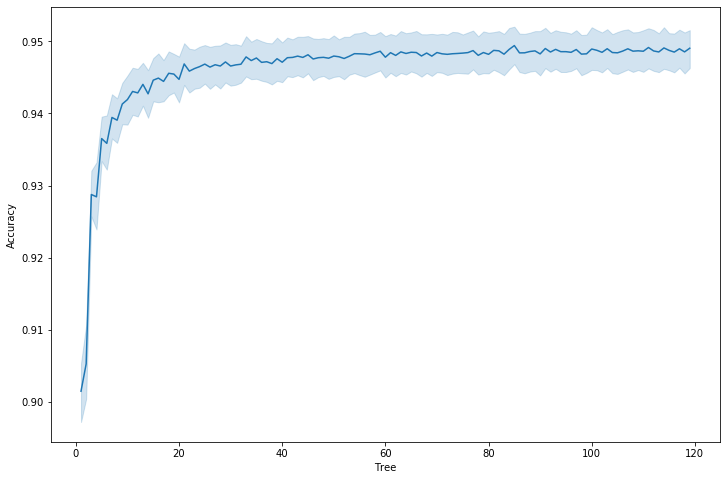

In [31]:
plt.figure(figsize=(12,8))
sns.lineplot(data = grid_acc[grid_acc['In_Bands']=='Spectrum_Normalize_Fourier_Terrain_Meterology'],
             x='Tree',
             y='Accuracy')

##### Observe that the Fourier bands significant increases the accuracy

In [32]:
# get the accuracy with the tree number of 100
Acc_tree_100 = grid_acc[grid_acc['Tree'] == 100]

In [33]:
Acc_tree_100

,Tree,CrossFolds,Accuracy,Year,In_Bands
396,100,split0_test_score,0.905690,1990_1992,Spectrum
397,100,split1_test_score,0.902070,1990_1992,Spectrum
398,100,split2_test_score,0.902468,1990_1992,Spectrum
399,100,split3_test_score,0.906449,1990_1992,Spectrum
872,100,split0_test_score,0.930760,1990_1992,Spectrum_Normalize
...,...,...,...,...,...
23247,100,split3_test_score,0.961385,2017_2019,Spectrum_Normalize_Fourier_Terrain
23720,100,split0_test_score,0.960207,2017_2019,Spectrum_Normalize_Fourier_Terrain_Meterology
23721,100,split1_test_score,0.960987,2017_2019,Spectrum_Normalize_Fourier_Terrain_Meterology
23722,100,split2_test_score,0.959395,2017_2019,Spectrum_Normalize_Fourier_Terrain_Meterology


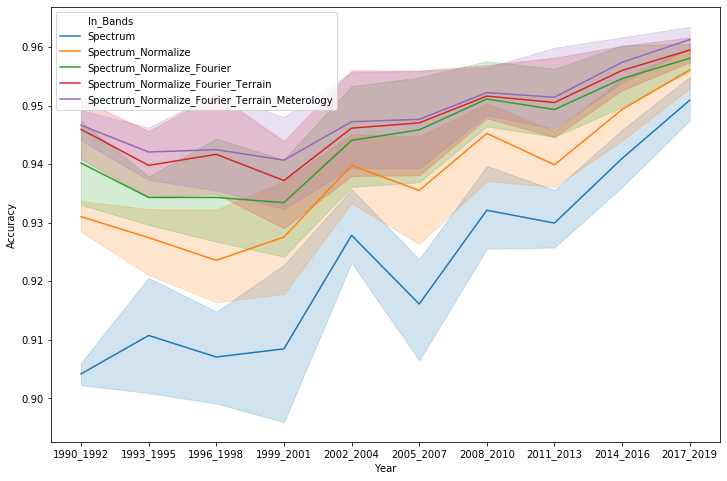

In [34]:
plt.figure(figsize=(12,8))
sns.lineplot(data = Acc_tree_100,
             x='Year',
             y='Accuracy',
             hue = 'In_Bands')

##### Just for fun: Use ANN(tf) to construct to classification moedl

In [35]:
# get one df for trying
fe = feature_df[-1]

# get the X and y
X = fe.drop('Built',1)
y = fe['Built']

# train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [36]:
# reshape the y values 
y_train = y_train.values.reshape([-1,1])
y_test = y_test.values.reshape([-1,1])

In [37]:
# scale the X values 
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit_transform(X_train)

X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

In [38]:
# construct the ANN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout

In [39]:
# built layers 
model = Sequential()

model.add(Dense(20,activation='relu'))
model.add(Dense(10,activation='relu'))
model.add(Dense(5,activation='relu'))
model.add(Dense(2,activation='relu'))

model.add(Dense(1,activation = 'sigmoid'))

model.compile(optimizer='adam',loss = 'binary_crossentropy')

In [40]:
# fit the model with X and y
model.fit(x=X_train,y=y_train,epochs=100,validation_data=(X_test,y_test))

Train on 6732 samples, validate on 3317 samples
Epoch 1/100
6732/6732 [==============================] - 1s 216us/sample - loss: 0.6044 - val_loss: 0.4562
Epoch 2/100
6732/6732 [==============================] - 0s 50us/sample - loss: 0.3989 - val_loss: 0.3630
Epoch 3/100
6732/6732 [==============================] - 0s 54us/sample - loss: 0.3424 - val_loss: 0.3296
Epoch 4/100
6732/6732 [==============================] - 0s 55us/sample - loss: 0.3092 - val_loss: 0.3011
Epoch 5/100
6732/6732 [==============================] - 0s 53us/sample - loss: 0.2837 - val_loss: 0.2805
Epoch 6/100
6732/6732 [==============================] - 0s 51us/sample - loss: 0.2639 - val_loss: 0.2818
Epoch 7/100
6732/6732 [==============================] - 0s 52us/sample - loss: 0.2495 - val_loss: 0.2578
Epoch 8/100
6732/6732 [==============================] - 0s 52us/sample - loss: 0.2343 - val_loss: 0.2570
Epoch 9/100
6732/6732 [==============================] - 0s 52us/sample - loss: 0.2230 - val_loss: 0.23

6732/6732 [==============================] - 0s 56us/sample - loss: 0.0994 - val_loss: 0.1171
Epoch 78/100
6732/6732 [==============================] - 0s 55us/sample - loss: 0.0977 - val_loss: 0.1289
Epoch 79/100
6732/6732 [==============================] - 1s 78us/sample - loss: 0.0987 - val_loss: 0.1185
Epoch 80/100
6732/6732 [==============================] - 0s 60us/sample - loss: 0.0981 - val_loss: 0.1149
Epoch 81/100
6732/6732 [==============================] - 0s 56us/sample - loss: 0.0967 - val_loss: 0.1155
Epoch 82/100
6732/6732 [==============================] - 0s 57us/sample - loss: 0.0955 - val_loss: 0.1169
Epoch 83/100
6732/6732 [==============================] - 0s 60us/sample - loss: 0.0975 - val_loss: 0.1159
Epoch 84/100
6732/6732 [==============================] - 0s 60us/sample - loss: 0.0964 - val_loss: 0.1175
Epoch 85/100
6732/6732 [==============================] - 0s 64us/sample - loss: 0.0946 - val_loss: 0.1215
Epoch 86/100
6732/6732 [==========================

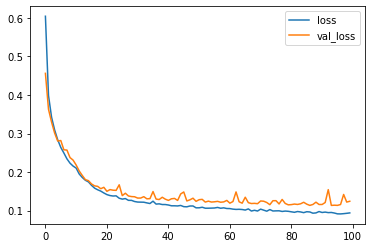

In [41]:
# plot the losses
losses = pd.DataFrame(model.history.history)
losses.plot()

In [42]:
# let's see the performance of the modle
from sklearn.metrics import classification_report,confusion_matrix
pred = model.predict_classes(X_test)

In [43]:
# print the classification report
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1646
           1       0.97      0.94      0.96      1671

    accuracy                           0.96      3317
   macro avg       0.96      0.96      0.96      3317
weighted avg       0.96      0.96      0.96      3317



In [44]:
# print the confusin matrix
print(confusion_matrix(y_test,pred))

[[1603   43]
 [  97 1574]]
